# Submission for Data Mining course Kaggle Competition
   
## "Determine the gender of Reddit authors using their comments"

### Student: Antonio Buono

### Matr.: 1018550

## Problem Assessment

Participants in the competition are asked to design a binary classification model capable of predicting the gender of Reddit users based on their comments on the platform. The training and test sets have already been defined beforehand in such a way that we should not need to worry about sampling bias and splitting procedures implementation (e.g. stratified sampling). Given the closed nature of the competition, we also won't address the problem of making our model easy to update with new training samples, allowing us to resort to batch-based learning algorithms if needed. Finally, the metric used for evaluation is defined as the area under the ROC Curve, defined as the True Positive Rate vs False Positive Rate graph as the decision boundary of the classificator is varied. Further description of the expected output format will be given later on this notebook. 

## Data Loading 

In [1]:
%pylab inline
import pandas as pd

train_data = pd.read_csv("train_data.csv", encoding="utf8")
train_data.info()

Populating the interactive namespace from numpy and matplotlib
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296042 entries, 0 to 296041
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   author       296042 non-null  object 
 1   subreddit    296042 non-null  object 
 2   created_utc  296042 non-null  float64
 3   body         296042 non-null  object 
dtypes: float64(1), object(3)
memory usage: 9.0+ MB


In [2]:
train_data.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [3]:
train_data["author"].value_counts()

morbiusgreen           19534
ProtoKun7               1524
IfImLateDontWait        1383
blaghart                1339
kkjdroid                1251
                       ...  
ss15                       1
LilBillysChubbyTits        1
SheltieNoises              1
oneIozz                    1
emptyRR                    1
Name: author, Length: 5000, dtype: int64

In [4]:
train_data["subreddit"].value_counts()

AskReddit                30884
ExploreFiction           15045
AskWomen                  8318
AskMen                    7734
AdviceAnimals             6866
                         ...  
WikiLeaks                    1
politicalfactchecking        1
gtaglitches                  1
CryptoCurrency               1
HangoutFest                  1
Name: subreddit, Length: 3468, dtype: int64

By giving a first look at the training data with the help of the DataFrame class methods `info()` and `head()`, we see that the dataset is comprised of 296042 entries, each containing the author's nickname, the subreddit on which the message was posted, the UTC timestamp and the text body of the message.<br>
The `value_counts()` method allows us to count the occurences of each single author and subreddit name, giving us 5000 different users writing in 3468 different communities.

In [5]:
target = pd.read_csv("train_target.csv", encoding="utf8")
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  5000 non-null   object
 1   gender  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [6]:
y = target.gender #isolating the gender labels
y

0       0
1       1
2       0
3       0
4       0
       ..
4995    0
4996    1
4997    0
4998    1
4999    0
Name: gender, Length: 5000, dtype: int64

To each author is associated a binary label which indicates his/her sex. The goal of the assignment is to structure a Dataframe which contains all the 5000 authors' names matched with the model-predicted probabilities of the writer being a man or a woman. 

## Feature Extraction

### Features from subreddit data

After loading the data we want to make it numerical so that our algorithms can work with it; we do this by vectorization of the subreddit list and messages corpus. We start by creating a mapping between single subreddits and integers.

In [7]:
from scipy import sparse #vectorizers typically output sparse matrices

#creating a mapper
subreddits = train_data.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0]))

subreddits_map

mylittlepony            0
sex                     1
DragonsDogma            2
malefashionadvice       3
todayilearned           4
                     ... 
palegirls            3463
onions               3464
mumfordandsons       3465
infertility          3466
HangoutFest          3467
Length: 3468, dtype: int32

We then define a function which creates the rows of the sparse matrix, one for each author; it contains a 1 in every column indicised with the integer corresponding to a specific subreddit, according to the mapping we just did. 

In [8]:
def extract_features(group):
    group_subreddits = group['subreddit']
    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values 
    idxs = subreddits_map.loc[group_subreddits].values 
    v = sparse.dok_matrix((1, subreddits.shape[0])) 
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1 
    return v.tocsr() 
    
extract_features(train_data[train_data.author=='morbiusgreen']) #the author morbiusgreen wrote in 17 different subreddits

<1x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

After doing this we run through all the authors and save the vectorized data in a dictionary and then in a 5000x3468 sparse matrix.

In [9]:
features_dict = {}

for author, group in train_data.groupby('author'):
    features_dict[author] = extract_features(group)
    
X = sparse.vstack([features_dict[author] for author in target.author])
X

<5000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 49152 stored elements in Compressed Sparse Row format>

In order to make the data more informative, we can also vectorize the data in such a way that each column of the resulting vector contains the ratio between messages written in the corresponding subreddit and the total number of messages written by the author. This kind of manipulation, however, moderately increases the code execution time.

In [10]:
def extract_features_frac(group):
    n_author = len(group) #total number of messages written by the same author
    group_subreddits = group['subreddit']
    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values 
    gs = pd.Series(data = group_subreddits)
    idxs = subreddits_map.loc[group_subreddits].values 
    v = sparse.dok_matrix((1, subreddits.shape[0])) 
    for idx in idxs:
        if not np.isnan(idx):
            n_sub = len(gs.loc[gs == subreddits_map.index[idx]]) #number of messages written by the same author in the same subreddit
            v[0, idx] = n_sub / n_author #in this way every row is normalized to 1
    return v.tocsr()

As we did before, we now create a dictionary and a sparse matrix containing numbers between 0 and 1.

In [11]:
features_dict_frac = {}

for author, group in train_data.groupby('author'):
    features_dict_frac[author] = extract_features_frac(group)
    
Xf = sparse.vstack([features_dict_frac[author] for author in target.author])
Xf

<5000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 49152 stored elements in Compressed Sparse Row format>

### Features from text data

We also will make use of the messagges' bodies to predict the authors' genders, so let's now vectorize the text data.

In [12]:
def extract_text(group):
    group_text = group['body'].astype(str).values #contains all messages from the same author
    return " ".join(group_text) #joins all message strings separated by a space

extract_text(train_data[train_data.author == 'TheKittyCannon']) #this author wrote 3 messages in two different subreddits

"We adopted a black greyhound which was racing in Iowa as well, probably one of the craziest dogs I've ever known. Love him to death though!  Did you adopt through HGA? Do it! Go adopt one, they will love you forever! From Iowa State, most of our team is flying... We also are paying about $500 round trip, and I'm not getting back home until Monday.  Our student body government doesn't really help out so look into doing a lot of fundraising if you plan to fly.  We have 2 team members driving and they plan on leaving 2 days early and getting back the following Wednesday."

As we did before, we create a dictionary which stores authors as keys and text messages from each author as values. To make sure that each document (i. e. collection of messages by the same author) is correctly paired to his author and that the list is in correspondance with the target order, we make use of the `OrderedDict` class.

In [13]:
from collections import OrderedDict

text_dict = {}

for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)

ord_text_dict = OrderedDict((author,text_dict[author]) for author in target.author) 

corpus = list(ord_text_dict.values()) 

Given the fact that some users wrote a lot more messages than others, it seem natural to vectorize the text by using the `TfidfVectorizer` transformation method, which natively returns normalized feature values.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

pattern ='(?u)\\b[A-Za-z]{3,}' #defining the allowed characters and stop words
stop_words = set(list(ENGLISH_STOP_WORDS) + ['http', 'https']) ##

tfidf = TfidfVectorizer(ngram_range = (1,2), stop_words= stop_words, min_df = .005, max_df = .2, token_pattern=pattern)
T = tfidf.fit_transform(corpus)
T

# min_df indicates the minimum fraction of documents in which a word must be in order to be counted; if  >1 it prevents overfitting 
# max_df indicates the maximum fraction of documents in which a word must be in order to be counted; if >0 it prevents underfitting

<5000x17349 sparse matrix of type '<class 'numpy.float64'>'
	with 1746983 stored elements in Compressed Sparse Row format>

In [15]:
vectfeatures = pd.DataFrame(T.toarray(), columns= tfidf.get_feature_names()) #shows the name of the features added by the vectorizer
vectfeatures.head()

,aaa,aaaaand,aaron,abandon,abandoned,abc,abide,abilities,ability,able afford,...,zen,zeppelin,zero,zip,zombie,zombies,zone,zones,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.064486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


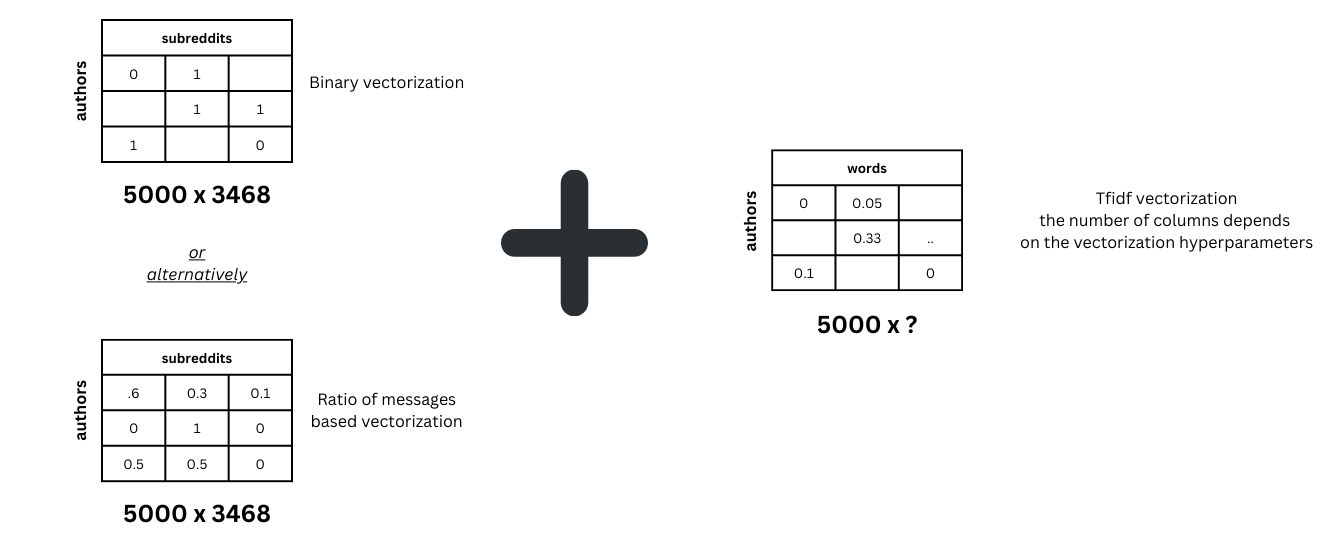

It may be useful, to experiment more easily with more vectorization parameters, to construct an `Extractor` which implements all the above feature extraction steps and combines the sparse matrices in which we encoded the data.

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin 
#BaseEstimator adds get_params() and set_params() methods
#TranformerMixin adds fit_transform() to transformer

class Extractor(BaseEstimator, TransformerMixin):
    def __init__(self, frac = False, min_df= 0.005, max_df=.2): #avoid *args and **kwargs
        self.frac = frac
        self.min_df = min_df  #tfidf parameters
        self.max_df = max_df  ##
    def fit(self, data, y = None):
        return self
    def transform(self, data, y):
        features_dict = {}
        text_dict = {}

        for author, group in data.groupby('author'): #text extraction
            text_dict[author] = extract_text(group)

        ord_text_dict = OrderedDict((author,text_dict[author]) for author in target.author)
        corpus = list(ord_text_dict.values()) 
        tfidf = TfidfVectorizer(ngram_range = (1,2), stop_words=stop_words, min_df= self.min_df, max_df= self.max_df, token_pattern=pattern)
        T = tfidf.fit_transform(corpus)

        if self.frac: #frac argument decides subreddit vectorization procedure
            for author, group in train_data.groupby('author'):
                features_dict[author] = extract_features_frac(group)

            X = sparse.vstack([features_dict[author] for author in target.author])

        else:
            for author, group in train_data.groupby('author'):
                features_dict[author] = extract_features(group)

            X = sparse.vstack([features_dict[author] for author in target.author])

        return sparse.hstack([X,T]).tocsr() #outputs an unique matrix with all features

In [17]:
extract = Extractor()
XT = extract.transform(train_data,y)
XT

<5000x20817 sparse matrix of type '<class 'numpy.float64'>'
	with 1796135 stored elements in Compressed Sparse Row format>

In [18]:
frac_extract = Extractor(frac=True)
XfT = frac_extract.transform(train_data,y)
XfT

<5000x20817 sparse matrix of type '<class 'numpy.float64'>'
	with 1796135 stored elements in Compressed Sparse Row format>

## Model Selection

We start our model selection by evaluating various models on the training set alone, just to get a feeling on which ones could be most effective.

In [19]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [20]:
def visualizer(pred,y): #function to display the ROC curve, given the estimator probability predictions
    fpr, tpr, thresholds = metrics.roc_curve(y,pred)
    roc_auc = metrics.auc(fpr,tpr)
    display = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc)
    display.plot()
    plt.show()

After experimenting with different classification models we noticed that ensemble methods (in particular the Random Forest Classifier) are the ones who better fit the training data and also return the highest cross-validation scores.

KNN Classifier heavily underfits the data.

As the Support Vector Machine classifier computational time scales with the product of the the number of samples and the number of features, it becomes really difficult in our case to explore the hyperparameter space using cross-validation and at the same time keep a relatively short execution time; furthermore, the classifier seems to be very sensitive to gamma and C (dramatically over- or under-fitting as they are even slightly changed), making the task of an exhaustive grid-search very much time-consuming. For these reasons we decided to discard the model as a meaningful way to describe the given problem.

Finally we also decided to include the Complement Naive Bayes Classifier, which is particularly suited for text-based data clasification, as it performs decently good in and out of sample. It can be reused in the final steps of our study as a way to construct an even more powerful classifier by combining it with other predictors in a `VotingClassifier` class.

### Random Forest 

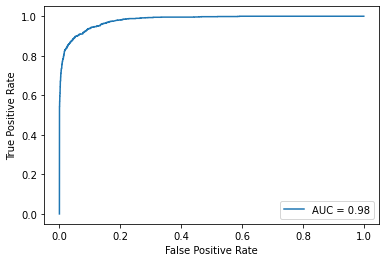

0.881243477623193


In [21]:
from sklearn.ensemble import RandomForestClassifier
#the predictor already contains the best hyperparameters found via grid search (as shown below)
forest = RandomForestClassifier(n_jobs=-1, n_estimators = 1200, max_depth=165, max_leaf_nodes=200, min_samples_leaf=10, bootstrap=False) #without regularization the model overfits
forest.fit(XT,y)
pred_forest = forest.predict_proba(XT)[:,1] #predicted probability for each class, the greatest label gives us the correct roc curve visualization
visualizer(pred_forest, y)
print(np.mean(cross_val_score(forest,XT,y,scoring='roc_auc'))) #cross validation score

### Naive Bayes

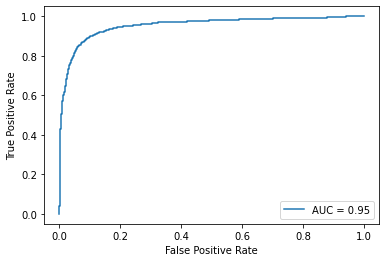

0.9048526113890866

In [22]:
from sklearn.naive_bayes import ComplementNB 
#particularly suited for text clasification and unbalanced datasets
nb_clf = ComplementNB()
nb_clf.fit(XT,y)
nb_pred = nb_clf.predict_proba(XT)[:,1]
visualizer(nb_pred,y)
np.mean(cross_val_score(nb_clf,XT,y,scoring='roc_auc'))

### Logistic Regression

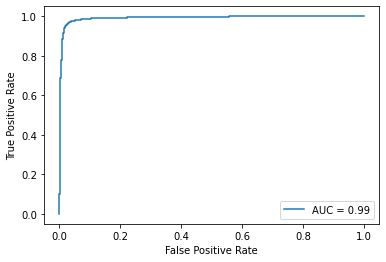

0.9079823366168718

In [120]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(XT,y)
pred_logistic = logistic.predict_proba(XT)[:,1]
visualizer(pred_logistic,y)
np.mean(cross_val_score(logistic, XT, y, scoring='roc_auc'))

## Fine-Tuning Models

We first employ hyper-parameters grid-search to the chosen models using our binary-encoded version of the subreddit submatrix (i.e. with our `frac` parameter set to `False`).

In [23]:
from sklearn.model_selection import GridSearchCV

In [25]:
#Random Forest Classifier grid search (frac=FALSE)
#values are only representative of the followed procedure
forest_grid = {'n_estimators': [1000,1200], 'max_depth': [165], 'max_leaf_nodes': [100,200],  'min_samples_leaf': [10,15]}
forest_GSCV = GridSearchCV(forest, forest_grid, cv=5, scoring='roc_auc', return_train_score=True)
forest_GSCV.fit(XT,y)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(bootstrap=False, max_depth=165,
                                              max_leaf_nodes=200,
                                              min_samples_leaf=10,
                                              n_estimators=1200, n_jobs=-1),
             param_grid={'max_depth': [165], 'max_leaf_nodes': [100, 200],
                         'min_samples_leaf': [10, 15], 'n_estimators': [1200]},
             return_train_score=True, scoring='roc_auc')

In [26]:
forest_GSCV.best_params_

{'max_depth': 165,
 'max_leaf_nodes': 200,
 'min_samples_leaf': 10,
 'n_estimators': 1200}

In [27]:
forest_res = forest_GSCV.cv_results_
for mean, params in zip(forest_res["mean_test_score"], forest_res["params"]):
    print(mean, params)

0.8806331085159572 {'max_depth': 165, 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'n_estimators': 1200}
0.880253032412637 {'max_depth': 165, 'max_leaf_nodes': 100, 'min_samples_leaf': 15, 'n_estimators': 1200}
0.8826196780477868 {'max_depth': 165, 'max_leaf_nodes': 200, 'min_samples_leaf': 10, 'n_estimators': 1200}
0.8804758279477177 {'max_depth': 165, 'max_leaf_nodes': 200, 'min_samples_leaf': 15, 'n_estimators': 1200}


Let's try the Random Forest Classifier with the fractional variant of the training set.

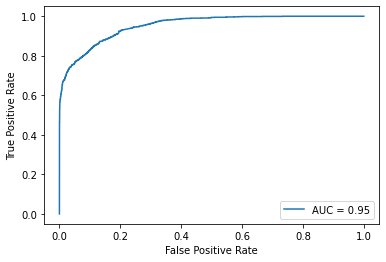

0.8666736275690348


In [28]:
frac_forest = RandomForestClassifier(n_estimators=5000, max_leaf_nodes=50, max_depth=10, bootstrap=False, n_jobs=-1)
frac_forest.fit(XfT,y)
frac_pred_forest = frac_forest.predict_proba(XfT)[:,1]
visualizer(frac_pred_forest,y)
print(np.mean(cross_val_score(frac_forest, XfT,y,scoring='roc_auc')))

In [29]:
frac_forest_grid = {'n_estimators':[5000], 'max_leaf_nodes':[20], 'max_depth':[20]}
frac_forest_GSCV = GridSearchCV(frac_forest, frac_forest_grid, cv=5, scoring='roc_auc', return_train_score=True)
frac_forest_GSCV.fit(XfT,y)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(bootstrap=False, max_depth=10,
                                              max_leaf_nodes=50,
                                              n_estimators=5000, n_jobs=-1),
             param_grid={'max_depth': [20], 'max_leaf_nodes': [20],
                         'n_estimators': [5000]},
             return_train_score=True, scoring='roc_auc')

In [30]:
frac_forest_GSCV.best_params_

{'max_depth': 20, 'max_leaf_nodes': 20, 'n_estimators': 5000}

In [31]:
frac_forest_res = frac_forest_GSCV.cv_results_
for mean, params in zip(frac_forest_res["mean_test_score"], frac_forest_res["params"]):
    print(mean, params)

0.8710900108102558 {'max_depth': 20, 'max_leaf_nodes': 20, 'n_estimators': 5000}


The results show no particular improvement of this fractional manipulation with respect to the original binary feature vectorization so from now on we'll use the `frac=Flase` parameter.

We can now use the attribute `feature_importances_` to list the ten most decisive features in the determination of the gender by the model. It's not very useful per se but it nonetheless gives a better insight on the model classification routine.

In [48]:
features_names = np.concatenate((subreddits_map.index,tfidf.get_feature_names())) #

important_dict = {'features':features_names,'importances': forest.feature_importances_}
important = pd.DataFrame().from_dict(important_dict)
print(important.nlargest(n=10,columns='importances'))

                features  importances
85       MakeupAddiction     0.031978
17              AskWomen     0.027133
4975           boyfriend     0.020812
59       TwoXChromosomes     0.016156
112    TrollXChromosomes     0.012259
10360            husband     0.010719
95                gaming     0.009907
103               videos     0.008980
12707             makeup     0.008766
6516                cute     0.007850


### XGBoost

The previous ensemble method (pasting via random trees) achieved a pretty good accuracy, so let's try the boosting ensemble method this time, by making use of a particularly suited library for text-based data classification.

In [34]:
import xgboost as xgb

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
Xtrain, Xval, ytrain, yval = train_test_split(XT,y, test_size=.2)

XGB = xgb.XGBClassifier(reg_alpha = 5, reg_lambda=5, max_depth = 2, max_leaves = 2, eval_metric=roc_auc_score)
XGB.fit(Xtrain,ytrain, eval_set=[(Xval,yval)])

[0]	validation_0-logloss:0.61537	validation_0-roc_auc_score:0.61244
[1]	validation_0-logloss:0.56876	validation_0-roc_auc_score:0.66158
[2]	validation_0-logloss:0.54542	validation_0-roc_auc_score:0.67849
[3]	validation_0-logloss:0.52766	validation_0-roc_auc_score:0.68658
[4]	validation_0-logloss:0.51565	validation_0-roc_auc_score:0.71642
[5]	validation_0-logloss:0.50626	validation_0-roc_auc_score:0.73559
[6]	validation_0-logloss:0.49862	validation_0-roc_auc_score:0.75633
[7]	validation_0-logloss:0.49240	validation_0-roc_auc_score:0.76419
[8]	validation_0-logloss:0.48798	validation_0-roc_auc_score:0.76478
[9]	validation_0-logloss:0.48258	validation_0-roc_auc_score:0.77327
[10]	validation_0-logloss:0.47820	validation_0-roc_auc_score:0.78038
[11]	validation_0-logloss:0.47377	validation_0-roc_auc_score:0.78561
[12]	validation_0-logloss:0.46944	validation_0-roc_auc_score:0.79678
[13]	validation_0-logloss:0.46505	validation_0-roc_auc_score:0.80444
[14]	validation_0-logloss:0.46327	validation

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x00000189B9BEF430>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=2, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

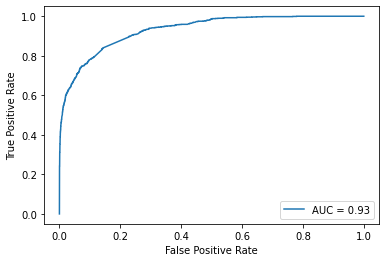

In [122]:
pred_XGB = XGB.predict_proba(Xtrain)[:,1]
visualizer(pred_XGB,ytrain)

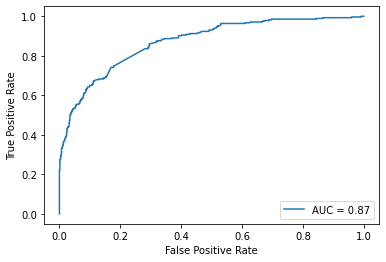

In [123]:
pred_XGB = XGB.predict_proba(Xval)[:,1]
visualizer(pred_XGB,yval)

In [124]:
print(np.mean(cross_val_score(XGB,XT,y,scoring='roc_auc')))

0.8731261648579725


## Voting Classifier

Finally, we'll join our best predictors' capabilities in a voting classifier, which should increase the expected out-of sample score.

In [129]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('XGB', XGB), ('forest', forest ), ('naive', nb_clf), ('logistic', logistic)],voting='soft')
voting_clf.fit(XT,y)
print(np.mean(cross_val_score(voting_clf,XT,y,scoring='roc_auc')))

0.924106839393388


## Solution Preparation

In [130]:
test_data = pd.read_csv("test_data.csv", encoding="utf8")
test_data.head()

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


In [131]:
final_features_dict = {}
for author, group in test_data.groupby('author'):
    final_features_dict[author] = extract_features(group)

In [132]:
X_test = sparse.vstack([final_features_dict[author] for author in test_data.author.unique()])
X_test

<15000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 144898 stored elements in Compressed Sparse Row format>

In [133]:
final_text_dict = {}
for author, group in test_data.groupby('author'):
    final_text_dict[author] = extract_text(group)

In [134]:
author_text_test = [final_text_dict[author] for author in test_data.author.unique()]
T_test = tfidf.transform(author_text_test)
T_test

<15000x17349 sparse matrix of type '<class 'numpy.float64'>'
	with 5099793 stored elements in Compressed Sparse Row format>

In [135]:
XT_test = sparse.hstack([X_test,T_test]).tocsr()
XT_test

<15000x20817 sparse matrix of type '<class 'numpy.float64'>'
	with 5244691 stored elements in Compressed Sparse Row format>

In [136]:
Y = voting_clf.predict_proba(XT_test)[:,1]

In [137]:
solution = pd.DataFrame({'author':test_data.author.unique(), 'gender':Y})
solution.head()

,author,gender
0,ejchristian86,0.893737
1,ZenDragon,0.050209
2,savoytruffle,0.111526
3,hentercenter,0.084371
4,rick-o-suave,0.257404


In [138]:
solution.to_csv("solution.csv", index=False)